In [ ]:
from pynq import allocate
from pynq import Overlay
import numpy as np
import struct
import ctypes
import numpy as np
import random
import matplotlib
from matplotlib import pyplot as plt
import time

In [ ]:
mnist = np.load("mnist-original.npy", allow_pickle= True)

X = mnist.item().get("data").T / 255
y = mnist.item().get("label")[0]

In [ ]:

weights = np.load('model_q.npy',allow_pickle=True)

fc1w = weights.item().get('fc1w_q')
fc1b = weights.item().get('fc1b_q')

fc2w = weights.item().get('fc2w_q')
fc2b = weights.item().get('fc2b_q')

fc3w = weights.item().get('fc3w_q')
fc3b = weights.item().get('fc3b_q')

In [ ]:
y

In [ ]:
mnist.item().get("label")

In [ ]:
fc1w

In [ ]:
fc3w.shape

In [ ]:
batch_size = 1

In [ ]:
def sign_bit2(a):
    if(a > 0):
        return 1
    else:
        return 0

sign_bit_map2 = np.vectorize(sign_bit2)

In [ ]:
# send channel ....

def parameter_converter(fc_weight):
    fc_q_t = sign_bit_map2(fc_weight)
    print("fc_q_t shape: ",fc_q_t.shape)
    print(fc_q_t)
    fc_shape = fc_q_t.shape
    row = fc_shape[0]
    col = fc_shape[1]
    ret = np.ndarray(((fc_q_t.shape[0] // 32)+ (0 if (fc_q_t.shape[0] % 32) == 0 else 1) , fc_q_t.shape[1]), dtype=np.uint32)
    print("ret shape: ", ret.shape)
    for i in range(col):
        tmp = 0
        for j in range(row):
            idx = j % 32
            tmp += (fc_q_t[j][i] << idx)
            if(j == row - 1 or idx == 31):
                ret[j//32][i] = tmp
                tmp = 0
    ret_np = ret.flatten()
    return ret_np


In [ ]:
fc1w_conv = parameter_converter(fc1w)
fc2w_conv = parameter_converter(fc2w)
fc3w_conv = parameter_converter(fc3w)

fc_q_t shape:  (784, 128)
[[0 1 1 ... 0 1 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 1 0 1]
 ...
 [1 1 1 ... 0 0 1]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 0 1 0]]
ret shape:  (25, 128)
fc_q_t shape:  (128, 64)
[[0 1 1 ... 0 0 1]
 [1 1 0 ... 1 0 1]
 [0 0 1 ... 0 1 1]
 ...
 [1 0 0 ... 1 1 1]
 [1 0 0 ... 1 0 1]
 [1 0 1 ... 1 1 1]]
ret shape:  (4, 64)
fc_q_t shape:  (64, 10)
[[0 1 0 1 0 0 0 1 0 0]
 [1 1 1 1 0 1 0 1 1 0]
 [1 0 1 1 0 1 1 0 1 0]
 [0 1 1 0 0 0 0 1 1 1]
 [1 1 1 0 1 0 1 0 0 1]
 [1 1 1 1 0 1 0 1 0 0]
 [1 0 0 1 1 1 1 0 0 1]
 [0 1 0 0 0 1 0 1 0 0]
 [1 0 1 1 0 0 0 1 1 1]
 [0 1 1 0 1 0 1 1 1 0]
 [1 0 1 1 0 0 0 1 0 1]
 [0 0 1 1 1 0 0 1 1 1]
 [1 0 0 1 0 0 1 1 1 0]
 [0 0 1 1 1 0 0 1 0 1]
 [1 0 1 0 1 0 0 1 0 1]
 [0 1 0 1 0 0 0 1 1 1]
 [0 0 1 0 1 0 1 1 1 0]
 [0 0 0 0 1 1 1 1 1 1]
 [1 0 1 1 0 0 1 0 0 0]
 [1 1 0 1 0 0 0 1 0 1]
 [0 0 0 1 1 0 0 1 0 1]
 [0 1 1 0 0 0 1 1 0 1]
 [1 0 1 1 0 1 1 0 0 0]
 [0 1 0 0 1 0 1 0 0 1]
 [1 0 0 1 0 0 1 1 0 0]
 [1 1 1 1 0 1 0 0 1 0]
 [0 1 0 1 1 1 1 0 1 1]
 [1 0 1 1 0 0 1 0 0 1]

In [ ]:
custom_hw = Overlay("fclayer_batch10_argmax.bit")
image_dma = custom_hw.image_dma
fc1w_dma = custom_hw.fc1w_dma
fc2w_dma = custom_hw.fc2w_dma
fc3w_dma = custom_hw.fc3w_dma
out_dma = custom_hw.out_dma

In [ ]:
image_buf = allocate((7840, ) , dtype=np.uint32)
fc1w_buf = allocate((3200, ) , dtype=np.uint32)
fc2w_buf = allocate((256, ) , dtype=np.uint32)
fc3w_buf = allocate((20, ) , dtype=np.uint32)
out_buf = allocate((10, ) , dtype=np.int16)

In [ ]:
image_buf = allocate((7840, ) , dtype=np.uint32)
fc1w_buf = allocate((3200, ) , dtype=np.uint32)
fc2w_buf = allocate((256, ) , dtype=np.uint32)
fc3w_buf = allocate((20, ) , dtype=np.uint32)
out_buf = allocate((100, ) , dtype=np.int16)

In [ ]:

np.copyto(fc1w_buf,fc1w_conv)
np.copyto(fc2w_buf,fc2w_conv)
np.copyto(fc3w_buf,fc3w_conv)

def image_quantize(a):
    if(a<0.3):
        return 0
    else:
        return 1

image_quantize_map = np.vectorize(image_quantize)

def feed_forward(X0):
    
    np.copyto(image_buf,image_quantize_map(X0.ravel()).astype(np.uint32)) 
    ##
    image_dma.sendchannel.transfer(image_buf)
    fc1w_dma.sendchannel.transfer(fc1w_buf)
    fc2w_dma.sendchannel.transfer(fc2w_buf)
    fc3w_dma.sendchannel.transfer(fc3w_buf)
    out_dma.recvchannel.transfer(out_buf)
    fc3w_dma.sendchannel.wait()
    fc2w_dma.sendchannel.wait()
    fc1w_dma.sendchannel.wait()
    image_dma.sendchannel.wait()
    out_dma.recvchannel.wait()
    ##
    return out_buf

'''
class my_ip():
    def init():
        ## send dma
        ## send dma 
        ## send dma
        
        ## ap_start = 1
        
    def computer(input_image):
'''
        

In [ ]:
np.argmax(feed_forward(X[40050]))

In [ ]:
y[40050]

In [ ]:
pixels = X[40050].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

In [ ]:
%%time
prediction = []
for idx in range(len(X)):
    xs = X[idx]
    ys = y[idx]
    output = feed_forward(xs)
    prediction.append(np.argmax(output) == (ys))
score = np.mean(prediction) * 100
print(score)

In [ ]:
def feed_forward3(X0):
    X0 = image_quantize_map(X0).astype(np.uint32)
    np.copyto(image_buf,X0)
        
    image_dma.sendchannel.transfer(image_buf)
    out_dma.recvchannel.transfer(out_buf)
    image_dma.sendchannel.wait()
    out_dma.recvchannel.wait()
    
    return out_buf

In [ ]:
%%time
batch_size = 10
prediction = []
for idx in range(len(X)//batch_size):
    xs = X[batch_size * idx : batch_size * idx + batch_size]
    ys = y[batch_size * idx : batch_size * idx + batch_size]
    outputs = feed_forward(xs).reshape((10,10))
    for output, yk in zip(outputs, ys):
        prediction.append(np.argmax(output) == (yk))

score = np.mean(prediction) * 100
print(score)

In [ ]:
%%time
X_flatten = X.flatten()

In [ ]:
start = time.time()
batch_size = 10
prediction = []
for idx in range(len(X)//batch_size):
    xs = X[batch_size * idx : batch_size * idx + batch_size]
    ys = y[batch_size * idx : batch_size * idx + batch_size]
    outputs = feed_forward(xs).reshape((10,10))
    #for output, yk in zip(outputs, ys):
        #prediction.append(output == (yk))
    for output, yk in zip(outputs, ys):
        prediction.append(np.argmax(output) == (yk))

score = np.mean(prediction) * 100
print(score)

end = time.time()
print("Elapsed time: ", end-start)

In [ ]:
feed_forward3(X[0])

In [ ]:
outputs = feed_forward(X[0:10])

In [ ]:
outputs

In [ ]:
start = time.time()
batch_size = 10
prediction = []
for idx in range(len(X)//batch_size):
    xs = X[batch_size * idx : batch_size * idx + batch_size]
    ys = y[batch_size * idx : batch_size * idx + batch_size]
    outputs = feed_forward(xs)
    for output, yk in zip(outputs, ys):
        prediction.append(output == (yk))
    #for output, yk in zip(outputs, ys):
        #prediction.append(np.argmax(output) == (yk))

score = np.mean(prediction) * 100
print(score)

end = time.time()
print("Elapsed time: ", end-start)

In [ ]:
feed_forward(X[40000:40010])

In [ ]:
%%time
feed_forward(X[0:10])

In [ ]:
%%time
batch_size = 10
prediction = []
for idx in range(len(X)//batch_size):
    xs = X[batch_size * idx : batch_size * idx + batch_size]
    ys = y[batch_size * idx : batch_size * idx + batch_size]
    outputs = feed_forward(xs)
    for output, yk in zip(outputs, ys):
        prediction.append(output == (yk))
    #for output, yk in zip(outputs, ys):
        #prediction.append(np.argmax(output) == (yk))

score = np.mean(prediction) * 100
print(score)

In [ ]:
Input = np.load('image_q.npy',allow_pickle=True)

X_q = Input.item().get('image')
y = Input.item().get("label")

In [ ]:
weights = np.load('model_q.npy',allow_pickle=True)

fc1w = weights.item().get('fc1w_q')
fc1b = weights.item().get('fc1b_q')

fc2w = weights.item().get('fc2w_q')
fc2b = weights.item().get('fc2b_q')

fc3w = weights.item().get('fc3w_q')
fc3b = weights.item().get('fc3b_q')

In [ ]:
np.copyto(fc1w_buf,fc1w_conv)
np.copyto(fc2w_buf,fc2w_conv)
np.copyto(fc3w_buf,fc3w_conv)

def feed_forward_imageq(X0):
    
    np.copyto(image_buf,X0) 
    ##
    image_dma.sendchannel.transfer(image_buf)
    fc1w_dma.sendchannel.transfer(fc1w_buf)
    fc2w_dma.sendchannel.transfer(fc2w_buf)
    fc3w_dma.sendchannel.transfer(fc3w_buf)
    out_dma.recvchannel.transfer(out_buf)
    fc3w_dma.sendchannel.wait()
    fc2w_dma.sendchannel.wait()
    fc1w_dma.sendchannel.wait()
    image_dma.sendchannel.wait()
    out_dma.recvchannel.wait()
    ##
    return out_buf

In [ ]:
%%time
batch_size = 10
prediction = []
for idx in range(len(X_q)):
    xs = X_q[idx]
    ys = y[10 * idx : 10 * idx + 10]
    outputs = feed_forward_imageq(xs)
    print(outputs)
    for output, yk in zip(outputs, ys):
        prediction.append(output == (yk))
    #for output, yk in zip(outputs, ys):
        #prediction.append(np.argmax(output) == (yk))

score = np.mean(prediction) * 100
print(score)

[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 6 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 2]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 2 0 7 0 0 0 0 0 0]
[0 0 2 0 0 0 0 0 0 0]
[3 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 6 0 0 0]
[0 0 0 0 0 6 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 6 6]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 7 0 0 0 0 0 5 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 6 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 2 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0

7000


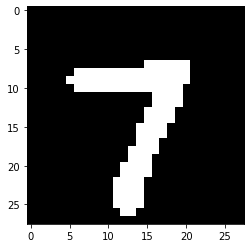

[7 1 7 7 7 7 7 7 7 7]


In [ ]:
print(len(X_q))
test = X_q[4600]
test_out = feed_forward_imageq(test)
#test_out = feed_forward(X[60000:67840])
pixels = X_q[4600][:784].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()
print(test_out)

In [ ]:
test.shape

In [ ]:
len(y)

In [ ]:
fc1w_dma.register_map.MM2S_DMACR.Reset = 1

In [ ]:
%%time
feed_forward(X[10:20])

In [ ]:
image_dma.register_map.MM2S_DMACR.Reset = 1

In [ ]:
fc1w_dma.register_map

In [ ]:
def feed_foward_sw(X0):
    X1 = np.matmul(X0, fc1w.T) + np.tile(fc1b, (batch_size, 1))
    A1 = np.tanh(X1)
    
    HW_result = np.matmul(A1, fc2w.T)

    X2 = HW_result + np.tile(fc2b, (batch_size, 1))
    A2 = np.tanh(X2)

    X3 = np.matmul(A2, fc3w.T) + np.tile(fc3b, (batch_size, 1))
    return X3

In [ ]:
weights = np.load('model_float.npy',allow_pickle=True)

fc1w = weights.item().get('fc1w')
fc1b = weights.item().get('fc1b')

fc2w = weights.item().get('fc2w')
fc2b = weights.item().get('fc2b')

fc3w = weights.item().get('fc3w')
fc3b = weights.item().get('fc3b')

In [ ]:
%%time
prediction = []
batch_size = 100
for idx in range(len(X)//batch_size):
    xs = X[batch_size * idx:batch_size * idx + batch_size]
    ys = y[batch_size * idx:batch_size * idx + batch_size]
    outputs = feed_foward_sw(xs)
    for output, yk in zip(outputs, ys):
        prediction.append(np.argmax(output) == (yk))

score = np.mean(prediction) * 100

print(score)